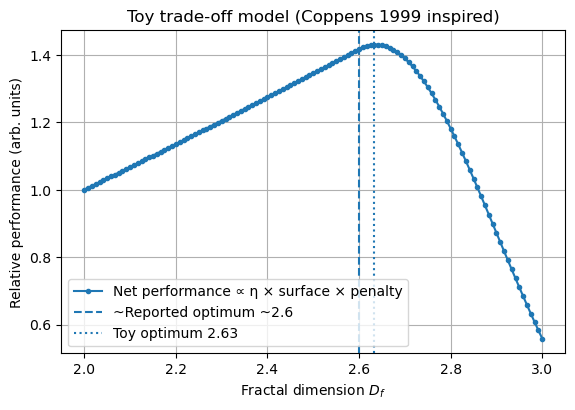

Toy optimum at Df ≈ 2.633, relative performance = 1.430
Parameters used: {'k': 1.0, 'L': 1.0, 'delta': 0.5, 's_exp': 1.25, 'Dcrit': 2.6, 'gamma': 7.0}


In [4]:
# Complete toy model from scratch: dual-effect (surface benefit × diffusion penalty × side-reaction penalty)
# Goal: produce an optimal fractal dimension around ~2.6, inspired by Coppens (1999).
import numpy as np
import matplotlib.pyplot as plt

# --- Physical-ish core: diffusion-reaction effectiveness via Thiele modulus with Df-dependent Knudsen diffusivity ---
def knudsen_diffusivity(Df, delta=0.5):
    """
    D_K ~ delta^(2 - Df). delta<1 gives decreasing D_K with larger Df (rougher -> harder diffusion).
    """
    return delta**(2.0 - Df)

def thiele_modulus(Df, k=1.0, L=1.0, delta=0.5):
    DK = knudsen_diffusivity(Df, delta=delta)
    return L*np.sqrt(k/np.maximum(DK, 1e-12))  # np.maximum으로 교체

def eta_effectiveness(phi):
    """
    First-order spherical effectiveness factor (classic closed form).
    """
    if np.isscalar(phi):
        if phi < 1e-8: 
            return 1.0
        return (3.0/phi)*(1.0/np.tanh(phi) - 1.0/phi)
    else:
        phi = np.asarray(phi, dtype=float)
        out = np.empty_like(phi)
        small = phi < 1e-8
        out[small] = 1.0
        ps = phi[~small]
        out[~small] = (3.0/ps)*(1.0/np.tanh(ps) - 1.0/ps)
        return out

# --- Empirical factors to encode "benefit" (surface area) and "additional penalty" (side reactions at very high Df) ---
def surface_benefit(Df, s_exp=1.2):
    """
    Monotonic increase with Df representing accessible surface/active sites growth.
    Normalized so that benefit=1 at Df=2.0.
    """
    return (Df/2.0)**s_exp

def side_reaction_penalty(Df, Dcrit=2.6, gamma=5.0):
    """
    Smooth penalty that activates for Df > Dcrit (excess hydrogenolysis/hydrocracking).
    exp(-gamma * (max(0, Df - Dcrit))^2) in [0,1].
    """
    excess = np.clip(Df - Dcrit, 0.0, None)
    return np.exp(-gamma * excess**2)

def net_performance(Df, k=1.0, L=1.0, delta=0.5, s_exp=1.2, Dcrit=2.6, gamma=5.0):
    phi = thiele_modulus(Df, k=k, L=L, delta=delta)
    eff = eta_effectiveness(phi)                    # diffusion penalty (via eta)
    benefit = surface_benefit(Df, s_exp=s_exp)      # surface benefit
    extra_penalty = side_reaction_penalty(Df, Dcrit=Dcrit, gamma=gamma)  # high-Df side reactions
    # Normalize to make magnitudes intuitive
    eff0 = eta_effectiveness(thiele_modulus(2.0, k=k, L=L, delta=delta))
    return (benefit * eff * extra_penalty) / eff0

# --- Sweep Df and plot ---
Df_vals = np.linspace(2.0, 3.0, 121)

# Tunable knobs chosen to place the optimum near ~2.6
params = dict(k=1.0, L=1.0, delta=0.5, s_exp=1.25, Dcrit=2.6, gamma=7.0)

perf = net_performance(Df_vals, **params)

# Find optimum
imax = int(np.argmax(perf))
Df_star = Df_vals[imax]
perf_star = perf[imax]

plt.figure(figsize=(6.5,4.2))
plt.plot(Df_vals, perf, "-o", markersize=3, label="Net performance ∝ η × surface × penalty")
plt.axvline(2.6, linestyle="--", label="~Reported optimum ~2.6")
plt.axvline(Df_star, linestyle=":", label=f"Toy optimum {Df_star:.2f}")
plt.xlabel("Fractal dimension $D_f$")
plt.ylabel("Relative performance (arb. units)")
plt.title("Toy trade-off model (Coppens 1999 inspired)")
plt.legend()
plt.grid(True)
plt.show()

print(f"Toy optimum at Df ≈ {Df_star:.3f}, relative performance = {perf_star:.3f}")
print("Parameters used:", params)
